In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1)

In [2]:
DATA_PATH = "data/"
TRAIN_DATA_FILE = "exoTrainData_upsampled.npy"
TRAIN_LABELS_FILE = "exoTrainLabels_upsampled.npy"
TEST_DATA_FILE = "exoTestData.npy"
TEST_LABELS_FILE = "exoTestLabels.npy"

x_train = np.load("{}{}".format(DATA_PATH, TRAIN_DATA_FILE))
y_train = np.load("{}{}".format(DATA_PATH, TRAIN_LABELS_FILE))
x_test = np.load("{}{}".format(DATA_PATH, TEST_DATA_FILE))
y_test = np.load("{}{}".format(DATA_PATH, TEST_LABELS_FILE))

# TODO: actually get this in some time units so can set autopower arg more legitimately
t = np.arange(x_train.shape[1])

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(10082, 3197)
(10082,)
(570, 3197)
(570,)


# Box Least Squares

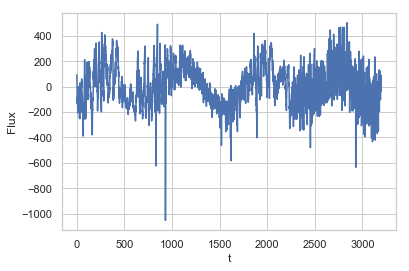

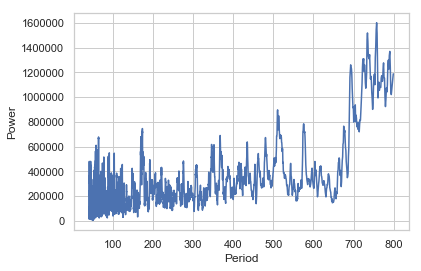

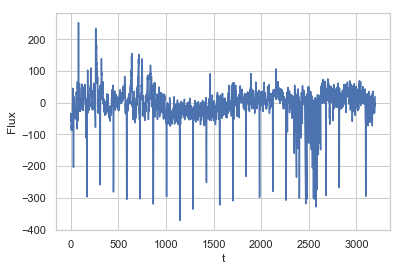

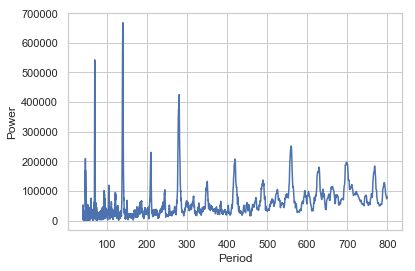

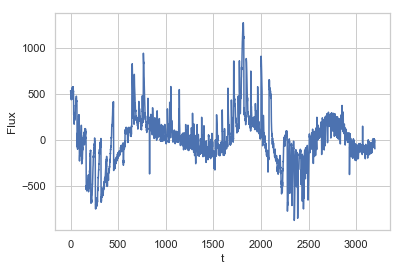

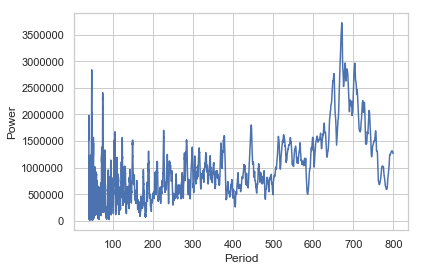

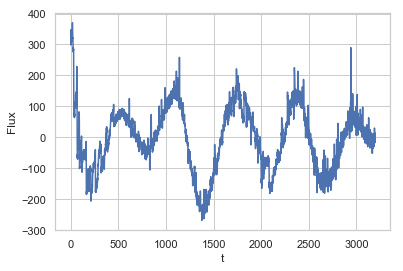

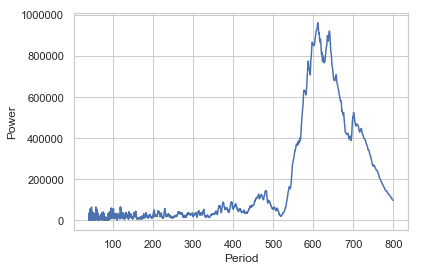

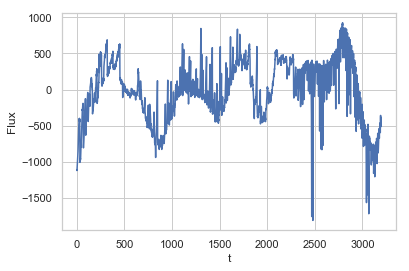

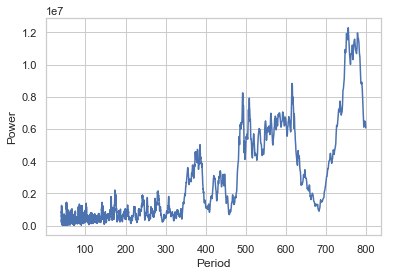

In [3]:
from astropy.stats import BoxLeastSquares

for i in range(5):
    plt.plot(t, x_train[i])
    plt.xlabel("t")
    plt.ylabel("Flux")
    plt.show()
    bls = BoxLeastSquares(t, x_train[i])
    periodogram = bls.autopower(20, minimum_n_transit=5)  # arg is the granularity of considered durations
    plt.plot(periodogram.period, periodogram.power)
    plt.xlabel("Period")
    plt.ylabel("Power")
    plt.show()

In [15]:
from sklearn import metrics

def compute_metrics(clf, x_train, y_train, x_test, y_test):
    print("Accuracy on training data:", clf.score(x_train, y_train))
    print("Accuracy on test data:", clf.score(x_test, y_test))
    test_predicted_probs = clf.predict_proba(x_test)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, test_predicted_probs)
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    print("AUC:", metrics.auc(fpr, tpr))
    test_predicted = clf.predict(x_test)
    print("F1:", metrics.f1_score(y_test, test_predicted))
    print("Test prediction frequencies:")
    print(np.unique(test_predicted, return_counts=True))
    print("Confusion matrix:")
    print(metrics.confusion_matrix(y_test, test_predicted))
    print()

In [5]:
from astropy.stats import BoxLeastSquares

stat_names = ["depth", "depth_odd", "depth_even", "depth_half", "depth_phased"]

def get_bls_features(x):
    features = []
    for i in range(x.shape[0]):
        # adapted from http://docs.astropy.org/en/stable/stats/bls.html#peak-statistics
        bls = BoxLeastSquares(t, x[i])
        periodogram = bls.autopower(40, minimum_n_transit=5)  # arg is the granularity of considered durations
        max_power = np.argmax(periodogram.power)
        stats = bls.compute_stats(periodogram.period[max_power],
                                    periodogram.duration[max_power],
                                    periodogram.transit_time[max_power])
        # TODO: use dataframe?
        features.append([stats[s][0] / stats[s][1] for s in stat_names])
        # based on https://arxiv.org/pdf/astro-ph/0206099.pdf
#         ratios.append(stats["depth"][0] / stats["depth"][1])  # depth over uncertainty
        if (i + 1) % 10 == 0:
            print(".", end="")
        if (i + 1) % 500 == 0:
            print()
    print()
    return np.array(features)

In [6]:
%%time

bls_train_features = get_bls_features(x_train)

..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
...............................

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
bls_train_features = scaler.fit_transform(bls_train_features)

In [11]:
from sklearn.linear_model import LogisticRegression

bls_logit = LogisticRegression()
bls_logit.fit(bls_train_features, y_train)

/home/czhao/.conda/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [12]:
print(bls_logit.coef_)
# print(bls_train_ratios.min(), bls_train_ratios.max())
# print("Ratio decision boundary:", -bls_logit.intercept_ / bls_logit.coef_)

# TODO: plot data with decision boundary

[[-0.84138073 -0.48409907 -1.00258244  2.18372072 -1.7496955 ]]


In [8]:
bls_test_features = get_bls_features(x_test)

..................................................
.......


In [13]:
bls_test_features = scaler.transform(bls_test_features)

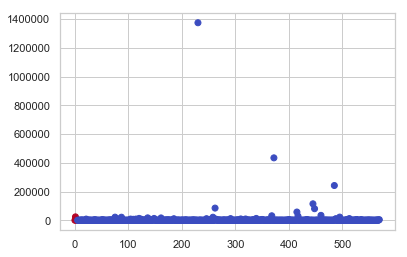

In [63]:
# plt.scatter(np.arange(bls_test_ratios.shape[0]), bls_test_ratios.flatten(), c=y_test, cmap="coolwarm")
# plt.show()

Accuracy on training data: 0.5273755207300139
Accuracy on test data: 0.956140350877193


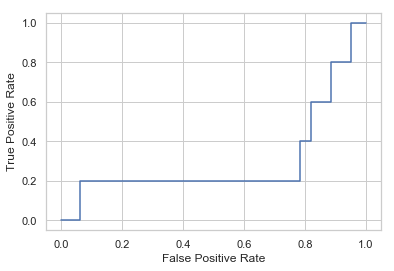

AUC: 0.2998230088495575
F1: 0.0
Test prediction frequencies:
(array([0., 1.]), array([550,  20]))
Confusion matrix:
[[545  20]
 [  5   0]]



In [16]:
compute_metrics(bls_logit, bls_train_features, y_train, bls_test_features, y_test)

# LSTM

In [104]:
%%time

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

BATCH_SIZE = 32
N_EPOCHS = 5
N_TRAIN = 1000 // BATCH_SIZE * BATCH_SIZE
N_TEST = x_test.shape[0] // BATCH_SIZE * BATCH_SIZE

model = Sequential([
    LSTM(8, input_shape=(x_train.shape[1], 1), batch_input_shape=(BATCH_SIZE, x_train.shape[1], 1), stateful=True),
    Dense(1),
])
# TODO: do balancing in a generator
model.compile(optimizer=Adam(1e-3), loss = 'binary_crossentropy', metrics=['accuracy'])
train_indices = np.random.choice(x_train.shape[0], N_TRAIN, replace=False)
x_train_lstm = x_train[train_indices, :, np.newaxis]
y_train_lstm = y_train[train_indices]
x_test_lstm = x_test[:N_TEST, :, np.newaxis]
y_test_lstm = y_test[:N_TEST]
train_accuracies = []
test_accuracies = []
for i in range(N_EPOCHS):
    hist = model.fit(x_train_lstm, y_train_lstm, validation_data=(x_test_lstm, y_test_lstm), epochs=1, batch_size=BATCH_SIZE, shuffle=False)
    model.reset_states()
    train_accuracies.append(hist.history["acc"])
    test_accuracies.append(hist.history["val_acc"])

Train on 992 samples, validate on 544 samples
Epoch 1/1
992/992 [==============================] - 98s 99ms/step - loss: 4.0887 - acc: 0.4516 - val_loss: 0.4270 - val_acc: 0.6452
Train on 992 samples, validate on 544 samples
Epoch 1/1
992/992 [==============================] - 81s 82ms/step - loss: 3.5411 - acc: 0.5121 - val_loss: 0.4983 - val_acc: 0.6066
Train on 992 samples, validate on 544 samples
Epoch 1/1
992/992 [==============================] - 85s 86ms/step - loss: 2.5778 - acc: 0.5202 - val_loss: 0.5371 - val_acc: 0.5919
Train on 992 samples, validate on 544 samples
Epoch 1/1
992/992 [==============================] - 83s 83ms/step - loss: 0.9991 - acc: 0.5252 - val_loss: 0.5321 - val_acc: 0.5956
Train on 992 samples, validate on 544 samples
Epoch 1/1
992/992 [==============================] - 92s 93ms/step - loss: 0.9428 - acc: 0.5373 - val_loss: 0.5201 - val_acc: 0.6103
CPU times: user 17min 34s, sys: 34min 48s, total: 52min 22s
Wall time: 7min 21s


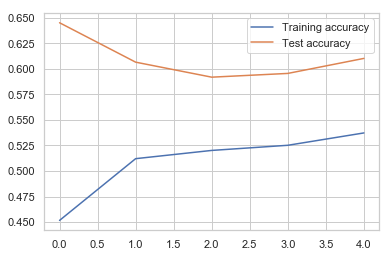

In [105]:
plt.plot(train_accuracies, label="Training accuracy")
plt.plot(test_accuracies, label="Test accuracy")
plt.legend()
plt.show()